# Sniffer Classifer
- Author: Sharon Fitzpatrick 
- Date April 2022
</br>
</br>
CNN that distinguishes between "good" and "bad" imagery. Based on the image sorting tool Sniffer. Intended purpose is to quickly sort through geospatial imagery and filter out bad imagery such as images with large segments missing, cloudy  images, or images with errors.

In [2]:
import matplotlib.pyplot as plt
from skimage import io
import datetime

import glob
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.metrics import BinaryAccuracy, FalseNegatives, FalsePositives, TrueNegatives,TruePositives, Precision, Recall, AUC

# Allows for matplot's to be displayed inline
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Local Variables
Use these variables to change the training parameters for your CNN.
- `dataset_path`: directory containing the  unzipped imagery
- `img_shape` : shape (width , height) your imagery will be resized to. These are inputs into the model.
- `imgs`: list containing all the jpgs  the model will be trained on

In [3]:
dataset_path=os.getcwd()+os.sep+"images"
imgs=glob.glob(dataset_path+os.sep+"*.jpg")
img_shape=(768, 768)
print("In {0} there are {1:n} images".format(dataset_path,len(imgs)))

In c:\1_USGS\CoastSeg\repos\6_sniffer-classifer\Sniffer-Classifier\images there are 2007 images


## Augmenting the Dataset
Create an image generator to apply augmentations to the imagery.
- standardizes the image sizes 
- applies zooms, flips, rotations to the imagery

In [4]:
train_datagen=ImageDataGenerator(
samplewise_std_normalization=True,
rotation_range=20,
zoom_range=0.05,
width_shift_range=0.05,
height_shift_range=0.05,
shear_range=0.05,
horizontal_flip=True,
fill_mode="nearest",
validation_split=0.20
)
# Not used at all in the code
test_datagen=ImageDataGenerator(samplewise_std_normalization=True,)


c:\Users\Sharon\anaconda3\envs\ml_learning\lib\site-packages\keras_preprocessing\image\image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


# Read in the  csv file and transform in df
1. Read in the csv
2. Clean the csv by dropping unused columns
3. Encode the categorical labels to binary labels consisting of 0 and 1

In [5]:
def clean_csv(csv: str):
    """Takes in the name of the csv file to clean (ex. 'master.csv') and a list labels to one hot encode.
        Returns the modified dataframe.
    """
    df =  pd.read_csv(csv)
    if "index" in df.columns:
        print("Dropping column index")
        df.drop(['index'],axis=1,inplace=True)
    if "Index" in df.columns:
        print("Dropping column Index")
        df.drop(['Index'],axis=1,inplace=True)
    if "Unnamed: 0"in df.columns:
        print("Dropping column Unnamed: 0")
        df.drop(['Unnamed: 0'],axis=1,inplace=True)
    if "Unnamed: 0.1"in df.columns:
        print("Dropping column Unnamed: 0.1")
        df.drop(['Unnamed: 0.1'],axis=1,inplace=True)
    return df

In [6]:
def binary_encode_labels(df:'pandas.core.frame.DataFrame',labels=["bad","good"]):
  """ Returns the modified dataframe with the labels encoded as binary labels of 0 and 1"""
  mapping = {}
  df["Filename"]=df["Filename"].astype(str)
  df["Sorted"]=df["Sorted"].astype(str)
  if df["Sorted"].str.contains('|'.join( ["good","bad"])).any():
    for x in range(len(labels)):
      mapping[labels[x]] = x
    # outputs {'good': 0, 'bad': 1}
    # Replace each label in sorted with corresponding one hot encoded label
    for x in range(len(df['Sorted'])):
      df['Sorted'][x] = mapping[df['Sorted'][x]]
    df["Sorted"]=df["Sorted"].astype(str)
  return df

In [7]:
def prep_dataset(csv:str):
    # Clean the dataset read from the csv file
    df=clean_csv(csv)
    # Encode the categorical labels to binary labels of 0 and 1
    df=binary_encode_labels(df)
    return df

In [8]:
df=prep_dataset("transfer_master.csv")
df

Dropping column Unnamed: 0


,Filename,Sorted
0,1984-09-21-15-11-10_L5_rgb.jpg,1
1,1984-09-21-15-11-34_L5_rgb.jpg,1
2,1984-11-08-15-10-58_L5_rgb.jpg,1
3,1984-11-08-15-11-22_L5_rgb.jpg,1
4,1984-11-24-15-10-57_L5_rgb.jpg,0
...,...,...
691,2017-11-12-18-52-31_L8_rgb.jpg,0
692,2017-11-20-15-37-50_L7_rgb.jpg,1
693,2017-11-21-18-46-17_L8_rgb_img.jpg,0
694,2017-11-28-18-52-24_L8_rgb.jpg,1


## Random OverSampling
Currently the dataset is imbalanced because the number of good and bad samples are not equal to each other.
Use Random oversampling so that the the number of samples in both classes are equal.

In [9]:
def random_oversampling(df,over_sample_class):
    """Apply random oversampling to the dataframe"""
    # Count the number of entries in both classes
    class_count_1,class_count_0=df['Sorted'].value_counts()['1'],df['Sorted'].value_counts()['0']
    # Divide the dataframe into the two classes
    class_0_df=df[df["Sorted"]=='0']
    # print(class_0_df)
    class_1_df=df[df["Sorted"]=='1']
    # print(class_1_df)
    # Oversample the the dataframe
    if over_sample_class == 0:
        # Oversample the 0 class by taking the class_0_df and use the df.sample() to create class_count_1 samples
        class_over_0=class_0_df.sample(class_count_1,replace=True)
        # Create a new dataframe with the oversampled class
        df =pd.concat([class_over_0,class_1_df],axis=0)
    elif over_sample_class == 1:
         # Oversample the 1 class by taking the class_1_df and use the df.sample() to create class_count_0 samples
        class_over_1=class_1_df.sample(class_count_0,replace=True)
        # Create a new dataframe with the oversampled class
        df =pd.concat([class_0_df,class_over_1],axis=0,ignore_index=True)
    return df

In [10]:
def apply_random_oversampling(df):
    """Apply random oversampling to the class with the least amount of samples"""
    labels=df['Sorted'].value_counts().index.tolist()
    if any("0" in word for word in labels ) and any("1" in word for word in labels):
        class_count_1,class_count_0=df['Sorted'].value_counts()['1'],df['Sorted'].value_counts()['0']
        if class_count_0 < class_count_1:
            # oversample class_count_0
            df=random_oversampling(df,0)
        elif  class_count_0 > class_count_1:
            # oversample class_count_1
            df=random_oversampling(df,1)
    return df

## Create the Data Generators
---

In [49]:
def get_training_dataframes(df):
    """Returns the training and test dataframes
    Splits the dataframe int a .75 and .25 training and test set respectively"""
    # Convert the sorted column to string otherwises data generators will not work
    df["Sorted"]=df["Sorted"].astype(str)
    # Shuffle the entries in the pandas dataframe
    shuffled_df=df.sample(frac=1,random_state=1).reset_index()
    # Split the dataframe into a train and test set into a .75 and .25 training and test set respectively
    # get the first 500 rows
    traindf=shuffled_df.iloc[:int(df.shape[0]*.75),:]
    # get the remaining rows
    testdf=shuffled_df.iloc[int(df.shape[0]*.75):,:]
    # Balance the traindf and testdf datasets
    traindf=apply_random_oversampling(traindf)
    testdf=apply_random_oversampling(testdf)
    traindf.drop(['index'],axis=1,inplace=True)
    testdf.drop(['index'],axis=1,inplace=True)
    return  traindf,testdf

In [50]:
traindf,testdf=get_training_dataframes(df)
traindf,testdf

(                           Filename Sorted
 229  2000-05-04-15-33-17_L7_rgb.jpg      0
 402  1991-09-25-15-05-23_L5_rgb.jpg      0
 27   2004-07-26-15-23-39_L5_rgb.jpg      0
 250  2011-10-27-18-40-09_L5_rgb.jpg      0
 36   1997-10-11-15-14-36_L5_rgb.jpg      0
 ..                              ...    ...
 515  1986-03-03-15-07-45_L5_rgb.jpg      1
 516  1999-04-08-15-20-08_L5_rgb.jpg      1
 517  1996-05-01-14-51-21_L5_rgb.jpg      1
 518  1986-09-27-15-01-13_L5_rgb.jpg      1
 520  1993-11-01-15-03-32_L5_rgb.jpg      1
 
 [794 rows x 2 columns],
                            Filename Sorted
 671  1991-06-05-15-03-50_L5_rgb.jpg      0
 550  2009-05-14-18-40-00_L5_rgb.jpg      0
 666  2013-11-10-18-47-48_L8_rgb.jpg      0
 635  2010-05-01-18-43-04_L5_rgb.jpg      0
 686  2001-07-26-15-30-17_L7_rgb.jpg      0
 ..                              ...    ...
 690  1993-04-23-15-03-52_L5_rgb.jpg      1
 692  2016-10-17-18-46-24_L8_rgb.jpg      1
 693  1989-10-21-15-06-20_L5_rgb.jpg      1
 694 

1    397
0    397
Name: Sorted, dtype: int64


<AxesSubplot:title={'center':'Count(target)'}>

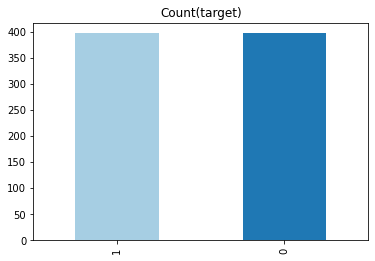

In [51]:
print(traindf['Sorted'].value_counts(ascending=True))
traindf['Sorted'].value_counts().plot(kind="bar",title='Count(target)',color=plt.cm.Paired(np.arange(len(traindf))))

0    129
1    129
Name: Sorted, dtype: int64


<AxesSubplot:title={'center':'Count(target)'}>

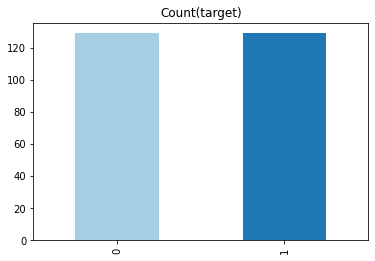

In [52]:
print(testdf['Sorted'].value_counts())
testdf['Sorted'].value_counts().plot(kind="bar",title='Count(target)',color=plt.cm.Paired(np.arange(len(testdf))))

In [15]:
def get_column_names(df):
    """ x (data) and y (labels) column names from the dataframe """
    x_col_name=df.columns[0]
    y_col_name=df.columns[1]
    return x_col_name,y_col_name

## Flow the images from the dataframe
- resize the images 
- shuffle the images
- divide the data into a training and validation subset
- set a random seed

In [16]:
# traindf,testdf=get_training_dataframes(df)
x_col_name,y_col_name=get_column_names(df)

train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name,   # image filenames
y_col=y_col_name,   # labels 
subset="training",
batch_size=21,
seed=42,
shuffle=True,
class_mode="binary",
target_size=img_shape)


Found 608 validated image filenames belonging to 2 classes.


In [17]:
valid_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name, 
y_col=y_col_name, 
subset="validation", 
batch_size=20, 
seed=42,
shuffle=True,
class_mode="binary",
target_size=img_shape)

Found 152 validated image filenames belonging to 2 classes.


## Create the Model
----
Create a simple Sequential Model

In [18]:
model_name="transfer_model_v_1_1"
model_path=os.getcwd()+ os.sep+"models"+os.sep+model_name
model = tf.keras.models.load_model(model_path+os.sep+"model")

In [97]:
# def myprint(s):
#     with open('modelsummary.txt','a') as f:
#         print(s, file=f)

# model.summary(print_fn=myprint)

In [19]:
model.summary(show_trainable=True)

Model: "model_4"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 768, 768, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 conv2d (Conv2D)                (None, 768, 768, 6)  78          ['input_1[0][0]']                N          
                                                                                                             
 batch_normalization (BatchNorm  (None, 768, 768, 6)  24         ['conv2d[0][0]']                 N          
 alization)                                                                                            

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
history=model.fit(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=4,
                     callbacks=[tensorboard_callback])

Epoch 1/4
28/28 [==============================] - 368s 13s/step - loss: 0.5558 - binary_accuracy: 0.7138 - val_loss: 0.4593 - val_binary_accuracy: 0.7891
Epoch 2/4
28/28 [==============================] - 355s 13s/step - loss: 0.5147 - binary_accuracy: 0.7632 - val_loss: 0.4827 - val_binary_accuracy: 0.7551
Epoch 3/4
28/28 [==============================] - 350s 12s/step - loss: 0.4908 - binary_accuracy: 0.7956 - val_loss: 0.4405 - val_binary_accuracy: 0.7959
Epoch 4/4
28/28 [==============================] - 387s 14s/step - loss: 0.4928 - binary_accuracy: 0.7853 - val_loss: 0.4117 - val_binary_accuracy: 0.8163


In [22]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 17468), started 0:48:49 ago. (Use '!kill 17468' to kill it.)

In [27]:
# It won't work if you run it from here instead open the terminal and run it from there.
# !tensorboard dev upload --logdir \
#     'logs/fit'

^C


## Evaluate Model Performance
---

In [28]:
score = model.evaluate(valid_generator)
print(score)

8/8 [==============================] - 80s 10s/step - loss: 0.9784 - binary_accuracy: 0.5855
[0.9784144163131714, 0.5855262875556946]


In [103]:
metrics_df = pd.DataFrame(history.history)
metrics_df

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.498530,0.775128,0.595625,0.721088
1,0.467886,0.809199,0.390150,0.857143


### Plot some graphs to evaluate the model performance

<AxesSubplot:>

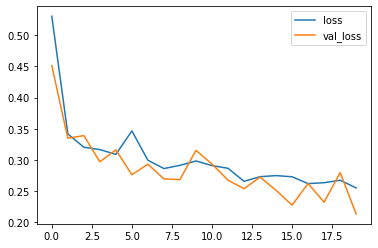

In [48]:
metrics_df[["loss","val_loss"]].plot()

<AxesSubplot:>

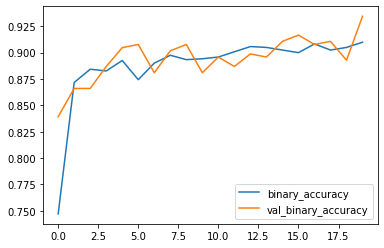

In [50]:
metrics_df[["binary_accuracy","val_binary_accuracy"]].plot()


In [29]:
metrics_df[["recall","val_recall"]].plot()

NameError: name 'metrics_df' is not defined

<AxesSubplot:>

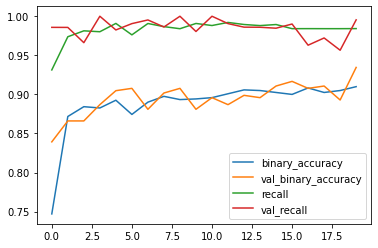

In [52]:
metrics_df[["binary_accuracy","val_binary_accuracy","recall","val_recall"]].plot()

## Save the Model and Training Metrics
1. Create a folder with the name of the model the user provides to store all the data in
2. Save the metrics dataframe as a csv
3. Save the actual model

In [30]:
def save_model_data(model_name:str,model:'keras.engine.sequential.Sequential'):
    # Create a directory to store all the model data
    model_save_path=os.getcwd()+os.sep+"models"
    if not os.path.exists(model_save_path):
        os.mkdir(model_save_path)
    model_save_path=os.getcwd()+os.sep+"models"+os.sep+model_name
    if os.path.exists(model_save_path):
        raise FileExistsError(f"This folder '{model_name}' already exists: {model_save_path}.\n Please rename your model.")
    else:
        os.mkdir(model_save_path)
    # Save the actual model
    model.save(model_save_path+os.sep+"model")

In [31]:
# Enter the name of your model
model_name="binary_classification_model_v_1_1_6"
# This might take a few seconds
save_model_data(model_name,model)

INFO:tensorflow:Assets written to: c:\1_USGS\CoastSeg\repos\6_sniffer-classifer\Sniffer-Classifier\models\binary_classification_model_v_1_1_6\model\assets
